In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.field_names import FieldName
from gluonts.mx.trainer.callback import TrainingHistory

from gluonts.time_feature import (
    day_of_week,
    day_of_month,
    day_of_year,
    week_of_year,
    month_of_year,
)

from gluonts.time_feature.holiday import (
   squared_exponential_kernel,
   SpecialDateFeatureSet,
   CHRISTMAS_DAY,
   CHRISTMAS_EVE
)

#### Read dataset

In [3]:
EVdata = pd.read_csv("stationAggDaytoDay2011_2020May12.csv", header = 0, index_col = 0)

In [4]:
EVdata = EVdata[EVdata['StartDate'] < '2020-07-01']

In [5]:
EVdata.set_index('StartDate', inplace=True)

In [6]:
EVdata.head()

,Station Name,counts,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons)
StartDate,,,,,
2011-10-13,BRYANT 1,2,8.262052,3.470,1.037
2011-10-14,BRYANT 1,1,6.259466,2.629,0.786
2011-10-15,BRYANT 1,1,4.622894,1.942,0.580
2011-10-17,BRYANT 1,1,4.023361,1.690,0.505
2011-10-18,BRYANT 1,1,15.474944,6.499,1.942


##### TestData: one time series

In [7]:
testData= EVdata.loc[EVdata["Station Name"] == "HAMILTON 1", ["counts", "Energy (kWh)"]]

In [8]:
testData = testData.rename(columns = {"Energy (kWh)": "target"})

In [9]:
testData["item_id"] = "HAMILTON 1"

In [10]:
testData.head()

,counts,target,item_id
StartDate,,,
2011-07-29,1,6.249457,HAMILTON 1
2011-07-30,5,28.978653,HAMILTON 1
2011-07-31,3,37.209163,HAMILTON 1
2011-08-01,1,5.041244,HAMILTON 1
2011-08-02,1,4.197217,HAMILTON 1


In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
def one_or_multiple_time_series(data, station_name_list, target, item_id, fields):
    '''
    purpose: 
        1. select one or multiple time series
        2. change the column names

    input variables:
        data: input dataframe
        station_name_list: the station name list (each one is a time series)
        target: the target variable name
        item_id: id of each time series, here it means station name list
        fields: input fields from the input data
    '''
    testData= data.loc[EVdata["Station Name"] == station_name_list, fields]
    testData = testData.rename(columns = {target: "target"})
    testData["item_id"] = item_id
    return testData

In [13]:
def multiple_time_series(data, target, fields):
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    testData = data.loc[:, fields]
    testData = testData.rename(columns = {target: "target"})
    testData['item_id'] = label_encoder.fit_transform(testData['Station Name'])
    station_name_map = testData[['Station Name', 'item_id']]
    testData.drop(columns = ['Station Name'], inplace = True)
    return testData, station_name_map

In [14]:
data = EVdata
station_name_list = "HAMILTON 1"
target = "Energy (kWh)"
item_id = "HAMILTON 1"
# fields = ["counts", "Energy (kWh)"]
fields = ["Station Name", "counts", "Energy (kWh)"]

# testData = one_or_multiple_time_series(EVdata, station_name_list, target, item_id, fields)
testData, station_name_map = multiple_time_series(EVdata, target, fields)
testData.head()


,counts,target,item_id
StartDate,,,
2011-10-13,2,8.262052,0
2011-10-14,1,6.259466,0
2011-10-15,1,4.622894,0
2011-10-17,1,4.023361,0
2011-10-18,1,15.474944,0


In [95]:
station_name_map[station_name_map["item_id"] == 30]

,Station Name,item_id
StartDate,,
2015-07-29,WEBSTER 1,30
2015-07-30,WEBSTER 1,30
2015-07-31,WEBSTER 1,30
2015-08-01,WEBSTER 1,30
2015-08-02,WEBSTER 1,30
...,...,...
2020-06-26,WEBSTER 1,30
2020-06-27,WEBSTER 1,30
2020-06-28,WEBSTER 1,30


#### Handle missing data

In [15]:
ds = PandasDataset.from_long_dataframe(testData, target="target", item_id="item_id", freq = "D")

In [16]:
max_end = max(testData.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in testData.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1D")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    dfs_dict[item_id][np.isnan(dfs_dict[item_id])] = 0
print(dfs_dict)

{0:             counts    target
2011-10-13     2.0  8.262052
2011-10-14     1.0  6.259466
2011-10-15     1.0  4.622894
2011-10-16     0.0  0.000000
2011-10-17     1.0  4.023361
...            ...       ...
2020-06-26     0.0  0.000000
2020-06-27     1.0  1.133000
2020-06-28     0.0  0.000000
2020-06-29     0.0  0.000000
2020-06-30     1.0  0.969000

[3184 rows x 2 columns], 1:             counts     target
2011-10-10     2.0  16.764479
2011-10-11     1.0  13.397377
2011-10-12     2.0  16.016336
2011-10-13     1.0  18.080227
2011-10-14     1.0   5.648643
...            ...        ...
2020-06-26     0.0   0.000000
2020-06-27     0.0   0.000000
2020-06-28     0.0   0.000000
2020-06-29     0.0   0.000000
2020-06-30     0.0   0.000000

[3187 rows x 2 columns], 2:             counts     target
2016-01-14     4.0  17.080252
2016-01-15     6.0  28.369562
2016-01-16     5.0  31.712811
2016-01-17     2.0   7.865278
2016-01-18     5.0  52.964527
...            ...        ...
2020-06-26     0.0  

In [17]:
ds = PandasDataset(dfs_dict, target="target")
counts = np.array([dfs_dict[item].loc[:, "counts"].to_numpy() for item in dfs_dict])
# counts = dfs_dict["HAMILTON 1"].loc[:, "counts"].to_numpy()

/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_34069/188289404.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  counts = np.array([dfs_dict[item].loc[:, "counts"].to_numpy() for item in dfs_dict])


#### Add multiple features

##### Number of counts

In [18]:
train_val_test_split = [0.7, 0.2, 0.1]
train_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[0])
validation_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[1])
prediction_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[2])

freq = "1D"
train_start = pd.Period('2011-07-29', freq = freq)

In [19]:
train_length, validation_length, prediction_length

(2228, 636, 318)

In [20]:
next(iter(ds))["target"].shape

(3184,)

In [21]:
next(iter(ds))["target"][: -prediction_length].shape

(2866,)

##### Temporal variables

In [22]:
holidat_set = SpecialDateFeatureSet([CHRISTMAS_EVE, CHRISTMAS_DAY])

In [23]:
data.head()

,Station Name,counts,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons)
StartDate,,,,,
2011-10-13,BRYANT 1,2,8.262052,3.470,1.037
2011-10-14,BRYANT 1,1,6.259466,2.629,0.786
2011-10-15,BRYANT 1,1,4.622894,1.942,0.580
2011-10-17,BRYANT 1,1,4.023361,1.690,0.505
2011-10-18,BRYANT 1,1,15.474944,6.499,1.942


In [24]:
start_date = data.index.min()
end_date = data.index.max()
start_date, end_date

('2011-07-29', '2020-06-30')

In [25]:
date_indices = pd.date_range(
    start = start_date,
    end = end_date,
    freq = 'D'
)

In [26]:
day_of_week_variable = np.array([day_of_week(date_indices) for item in ds])

day_of_month_variable = np.array([day_of_month(date_indices) for item in ds])
day_year_variable = np.array([day_of_year(date_indices) for item in ds])
week_of_year_variable = np.array([week_of_year(date_indices) for item in ds])
month_of_year_variable = np.array([month_of_year(date_indices) for item in ds])

In [27]:
len(day_of_week_variable[0])

3260

In [28]:
len(day_of_week_variable[0][:train_length])

2228

#### Use train and split

In [29]:
max_length = max(len(item['target']) for item in ds)
padded_targets = [np.pad(arr['target'], (max_length - len(arr['target']), 0), mode='constant') for arr in ds]
target = np.vstack(padded_targets)
# next(iter(ds))["target"][: train_length].reshape(1, next(iter(ds))["target"][: train_length].shape[0])

In [30]:
start = np.array([item['start'] for item in ds])

In [31]:
max_length = max(len(item) for item in counts)
padded_counts = [np.pad(arr, (max_length - len(arr), 0), mode='constant') for arr in counts]
counts = np.vstack(padded_counts)

In [32]:
target

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.969],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., 22.764,  9.425,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ..., 13.803, 18.608, 19.683],
       [ 0.   ,  0.   ,  0.   , ...,  5.935,  0.065, 58.624],
       [ 0.   ,  0.   ,  0.   , ...,  0.   , 27.877, 23.996]])

In [33]:
target.ndim

2

In [34]:
len(target[:, :train_length])

33

In [35]:
start_date_period = pd.Period(data.index.min(), freq='D')
start = [start_date_period for _ in range(len(target))]
start

[Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D')]

In [36]:
freq

'1D'

In [37]:
len(target[:, :train_length][0])

2228

In [38]:
len(day_of_week_variable[:][:train_length][0])

3260

In [39]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            target[:, :train_length],
            start,
            counts[:, :train_length],
            day_of_week_variable[:, :train_length],
            month_of_year_variable[:, :train_length]
        )
    ],
    freq=freq,
)

In [40]:
val_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            target[:, :-prediction_length],
            start,
            counts[:, :-prediction_length],
            day_of_week_variable[:, :-prediction_length],
            month_of_year_variable[:, :-prediction_length]
        )
    ],
    freq=freq,
)

In [41]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            target,
            start,
            counts,
            day_of_week_variable,
            month_of_year_variable
        )
    ],
    freq=freq,
)

In [42]:
def check_train_val_test_data(train_ds, val_ds, test_ds):
    print("training data: \n \t {} \n".format(train_ds))
    print("validation data: \n \t {} \n".format(val_ds))
    print("testing data: \n \t {} \n".format(test_ds))

In [43]:
check_train_val_test_data(train_ds, val_ds, test_ds)

training data: 
 	 [{'target': array([ 0.   ,  0.   ,  0.   , ..., 23.222, 58.488, 23.058], dtype=float32), 'start': Period('2011-07-29', 'D'), 'feat_dynamic_real': array([[0.        , 0.        , 0.        , ..., 2.        , 4.        ,
        2.        ],
       [0.16666667, 0.33333334, 0.5       , ..., 0.        , 0.16666667,
        0.33333334],
       [0.04545455, 0.04545455, 0.04545455, ..., 0.13636364, 0.22727273,
        0.22727273]], dtype=float32)}, {'target': array([ 0.   ,  0.   ,  0.   , ..., 28.246, 25.99 ,  2.288], dtype=float32), 'start': Period('2011-07-29', 'D'), 'feat_dynamic_real': array([[0.        , 0.        , 0.        , ..., 3.        , 4.        ,
        1.        ],
       [0.16666667, 0.33333334, 0.5       , ..., 0.        , 0.16666667,
        0.33333334],
       [0.04545455, 0.04545455, 0.04545455, ..., 0.13636364, 0.22727273,
        0.22727273]], dtype=float32)}, {'target': array([ 0.   ,  0.   ,  0.   , ..., 24.135, 33.996,  9.856], dtype=float32), 's

#### Visualize the dataset

In [44]:
def visualize_train_val_test_data(train_ds, val_ds, test_ds):
    train_entry = next(iter(train_ds))
    train_series = to_pandas(train_entry)
    
    val_entry = next(iter(val_ds))
    val_series = to_pandas(val_entry)

    test_entry = next(iter(test_ds))
    test_series = to_pandas(test_entry)

    plt.figure(figsize=(10, 6))
    
    test_series.plot(color = "grey")
    plt.axvline(train_series.index[-1], color="red")  # end of train dataset
    plt.axvline(val_series.index[-1], color="blue")  # end of train dataset
    plt.grid(which="both")
    plt.legend(["test series", "end of train series", "end of val series"], loc="upper left")
    plt.show()

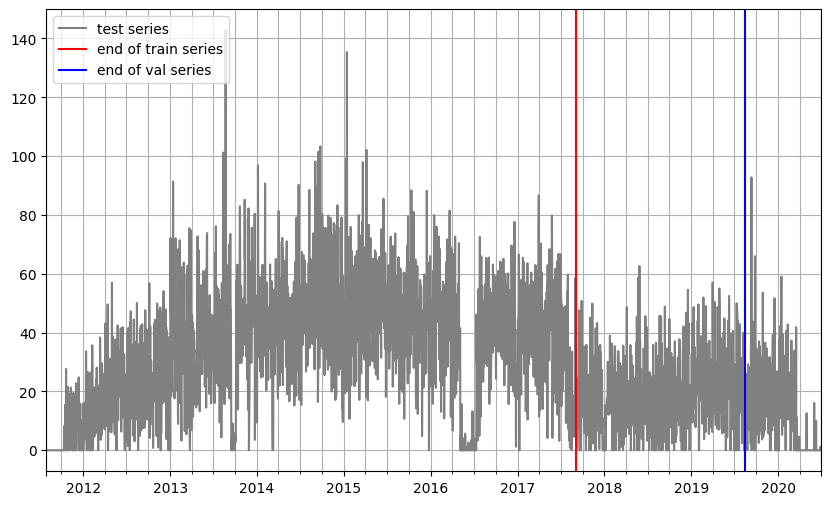

In [45]:
visualize_train_val_test_data(train_ds, val_ds, test_ds)

#### Train and prediction

##### Simple feed forward estimator

In [46]:
# defining a callback, which will log the training loss for each epoch
history = TrainingHistory()

In [47]:
simple_feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[50], ## default: 50
    prediction_length=prediction_length,
    batch_normalization = False, ## default: false
    mean_scaling = True, ## default: true
    context_length=100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### MQCNN estimator

In [48]:
from gluonts.mx import MQCNNEstimator, Trainer

In [49]:
mqcnn_estimator = MQCNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    use_feat_dynamic_real=True,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### MQRNN estimator

In [50]:
from gluonts.mx import MQRNNEstimator, Trainer

In [51]:
mqrnn_estimator = MQRNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepAR estimator

In [52]:
from gluonts.mx import DeepAREstimator, Trainer

In [53]:
deepAR_estimator = DeepAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=8, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepVAR estimator

In [54]:
from gluonts.mx import DeepVAREstimator, Trainer

In [96]:
deepVAR_estimator = DeepVAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    target_dim= 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=2, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### LSTNet

In [56]:
from gluonts.mx import LSTNetEstimator, Trainer

In [99]:
lstnet_estimator = LSTNetEstimator(
    num_series = 46,
    prediction_length = prediction_length,
    ar_window = 10,
    channels = 1,
    context_length = 20,
    skip_size = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=2, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Temporal fusion transformer

In [58]:
from gluonts.mx import TemporalFusionTransformerEstimator, Trainer

In [103]:
tft_estimator = TemporalFusionTransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    hidden_dim = 20,
    trainer=Trainer(
        ctx="cpu", 
        epochs=2, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Transformer estimator

In [60]:
from gluonts.mx import TransformerEstimator, Trainer

In [61]:
transformer_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    context_length = 100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Deepfactor estimator

In [62]:
from gluonts.mx import DeepFactorEstimator, Trainer

In [108]:
deepFactor_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### GP estimator

In [64]:
from gluonts.mx import GaussianProcessEstimator, Trainer

In [84]:
gp_estimator = GaussianProcessEstimator(
    freq = freq,
    prediction_length = prediction_length,
    cardinality = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Naive predictor

In [67]:
from gluonts.ext.naive_2 import Naive2Predictor

In [68]:
naive_predictor = Naive2Predictor(
    prediction_length = prediction_length,
    season_length = 100
)

##### Train and predict

In [69]:
def train_and_predict(train_dataset, val_dataset, test_dataset, estimator):
    predictor = estimator.train(training_data = train_dataset, validation_data = val_dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset = test_dataset, predictor = predictor
    )
    
    return predictor, list(forecast_it), list(ts_it)


In [70]:
def get_model_name(estimator):
    s = str(estimator)

    start_marker = ".model."
    end_marker = "._estimator"

    start_index = s.find(start_marker)
    if(start_index == -1):
        raise ValueError("Couldn't find start index!")

    end_index = s.find(end_marker, start_index)
    if(end_index == -1):
        return ValueError("Couldn't find end index!")
    
    start_index += len(start_marker)
    return s[start_index: end_index]

In [71]:
def multiple_models(train_ds, val_ds, test_ds, estimators):
    for estimator in estimators:
        
        ## model training
        predictor, forecast_it, ts_it = train_and_predict(train_ds, val_ds, test_ds, estimator)

        ## loss curve
        loss_data_framework = get_loss_curve(history)
        print("loss curve")
        print(loss_data_framework)
        export_loss_curve(loss_data_framework, estimator)
        plot_loss_curve(loss_data_framework)

        ## evluation metrics
        print_forecast_basic_info(forecast_it, ts_it)
        export_original_time_series_no_missing_values(ts_it)
        export_predicted_values(ts_it, forecast_it, estimator)
        plot_orginal_prediction(forecast_it, ts_it, estimator)
        agg_metrics, item_metrics = get_evaluation_metrics(forecast_it, ts_it)
        export_eval_metrics(agg_metrics, item_metrics, estimator)

        return predictor, agg_metrics, item_metrics, forecast_it, ts_it
    

In [72]:
def get_loss_curve(history):
    loss_data_framework = pd.DataFrame({
        "training_loss": history.loss_history,
        "val_loss": history.validation_loss_history
    })
    loss_data_framework.head()
    return loss_data_framework

In [73]:
def export_loss_curve(loss_data_framework, estimator):
    loss_curve_name = "loss_curve_model_{}.csv".format(get_model_name(estimator))
    loss_data_framework.to_csv(loss_curve_name)

In [74]:
def plot_loss_curve(loss_data_framework):
    # Clear the current figure
    plt.clf()
    
    loss_data_framework.plot()

In [75]:
def print_forecast_basic_info(forecast_it, ts_it):
    forecast_entry = forecast_it[0]
    ts_entry = ts_it[0]

    print(f"Number of sample paths: {forecast_entry.num_samples}")
    print(f"Dimension of samples: {forecast_entry.samples.shape}")
    print(f"Start date of the forecast window: {forecast_entry.start_date}")
    print(f"Frequency of the time series: {forecast_entry.freq}")

In [76]:
def export_original_time_series_no_missing_values(ts_it):

    ts_entry = ts_it[0]
    
    time_series_original = pd.DataFrame(ts_entry)
    time_series_original.columns = ['true_value']
    time_series_original.to_csv("time_series_original_no_missing_values.csv")

In [77]:
def export_predicted_values(ts_it, forecast_it, estimator):
    forecast_entry = forecast_it[0]
    ts_entry = ts_it[0]
    
    predicted_values = "predicted_values_model_{}.csv".format(get_model_name(estimator))
    predicted_values_100_series = pd.DataFrame(forecast_entry.samples.T)
    predicted_values_100_series.to_csv(predicted_values)

In [78]:
def plot_orginal_prediction(forecast_it, ts_it, estimator):
    # Clear the current figure
    plt.figure(figsize=[10, 6])
    
    samples = [0, 10, 20, 30]
    for i in samples:
        plt.clf()
        forecast_entry = forecast_it[i]
        ts_entry = ts_it[i]

        plt.plot(ts_entry[-800:].to_timestamp())
        forecast_entry.plot(show_label=True)
        plt.legend()
        plt.savefig("testing_{}{}.png".format(get_model_name(estimator), i))

In [79]:
def get_evaluation_metrics(forecast_it, ts_it):

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it)

    return agg_metrics, item_metrics

In [80]:
def export_eval_metrics(agg_metrics, item_metrics, estimator):
    ## agg_metrics
    print("Evaluation metrics: {}".format(get_model_name(estimator)))
    agg_metrics_data_frame = pd.DataFrame([agg_metrics])

    agg_metrics_csv_name = "agg_metrics_{}.csv".format(get_model_name(estimator))

    item_metrics_csv_name = "item_metrics_{}.csv".format(get_model_name(estimator))

    agg_metrics_data_frame.to_csv(agg_metrics_csv_name)
    item_metrics.to_csv(item_metrics_csv_name)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:50<00:00,  1.71s/it, epoch=1/10, avg_epoch_loss=3.23]
2it [00:00,  4.79it/s, epoch=1/10, validation_avg_epoch_loss=4.44]
100%|██████████| 100/100 [02:40<00:00,  1.60s/it, epoch=2/10, avg_epoch_loss=2.04]
2it [00:00,  4.93it/s, epoch=2/10, validation_avg_epoch_loss=4.19]
100%|██████████| 100/100 [02:41<00:00,  1.62s/it, epoch=3/10, avg_epoch_loss=1.61]
2it [00:00,  5.05it/s, epoch=3/10, validation_avg_epoch_loss=4.23]
100%|██████████| 100/100 [02:40<00:00,  1.60s/it, epoch=4/10, avg_epoch_loss=1.3]
2it [00:00,  4.43it/s, epoch=4/10, validation_avg_epoch_loss=4.16]
100%|██████████| 100/100 [02:40<00:00,  1.60s/it, epoch=5/10, avg_epoch_loss=1.11]
2it [00:00,  5.08it/s, epoch=5/10, validation_avg_epoch_loss=4.34]
100%|██████████| 100/100 [02:40<00:00,  1.61s/it, epoch=6/10, avg_epoch_loss=0.91]
2it [00:00,  5.04it/s, epoch=6/10, validation_avg_epoch_loss=4.57]
100%|██████████| 100/100 [02:32<00:00,  1.52s/it, epoch=7/10, avg_epoch_loss=0.572]
2it [00:00,  5.46

loss curve
    training_loss     val_loss
0     1284.779222  1596.629674
1     1092.040961  1471.695278
2     1091.277576  1501.683762
3      826.826351  1407.994119
4      693.708393  1368.445213
5      629.319811  1351.323872
6      595.463332  1344.594289
7      577.714963  1343.036835
8      567.325261  1342.849491
9      562.576635  1342.665684
10     559.547219  1342.571954
11     557.416164  1342.553332
12       1.891195     4.540184
13       3.318910     4.421125
14       2.372866     4.205564
15       3.234303     4.443544
16       2.038984     4.187578
17       1.609488     4.226727
18       1.296528     4.155793
19       1.110093     4.338846
20       0.910346     4.573749
21       0.572072     4.558667
22       0.481662     4.623801
23       0.470739     4.570694
24       0.278055     4.591719
Number of sample paths: 100
Dimension of samples: (100, 318)
Start date of the forecast window: 2019-08-18
Frequency of the time series: <Day>


Running evaluation: 33it [00:00, 83.38it/s]


Evaluation metrics: transformer


<Figure size 640x480 with 0 Axes>

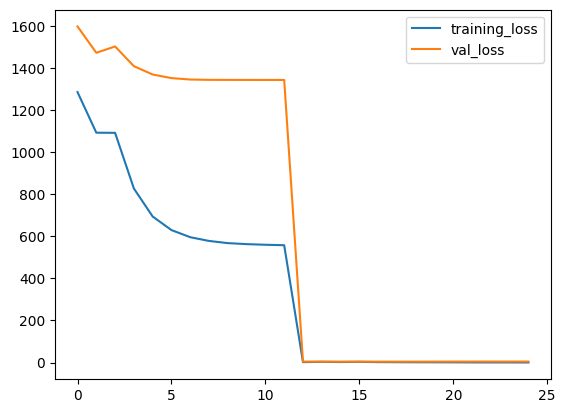

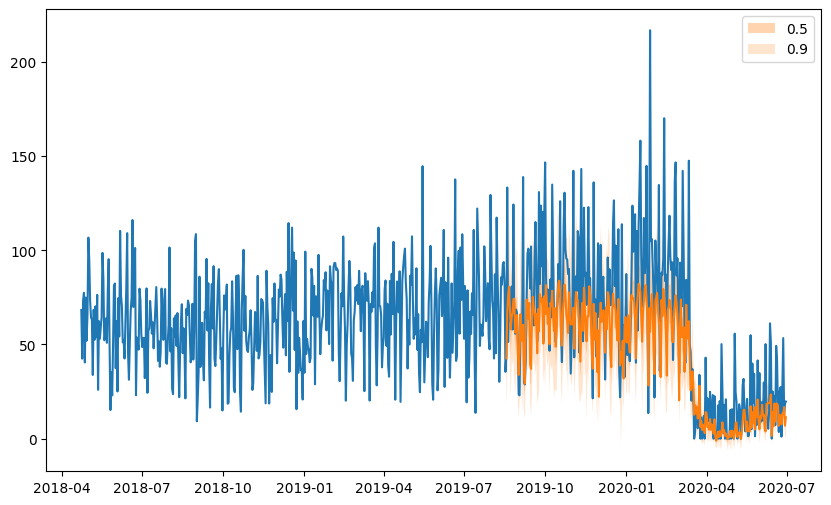

In [109]:
## Available estmators: 
## transformer_estimator: transformer
## tft_estimator: temporal fusion transformer
## lstnet_estimator: LSTnet
## deepVAR_estimator: DeepVAR
## deepAR_estimator: DeepAR
## simple_feed_forward_estimator: MLP
## deepFactor_estimator: deep factor
## gp_estimator: gaussian process
## mqcnn_estimator: MQ CNN
## rnn_estimator: RNN

# estimators = [simple_feed_forward_estimator, \
#               deepAR_estimator, \
#               deepVAR_estimator, \
#               lstNetEstimator, \
#               transformer_estimator, \
#               mqcnn_estimator]

estimators = [deepFactor_estimator]

predictor, agg_metrics, item_metrics, forecast_it, ts_it = multiple_models(train_ds, val_ds, test_ds, estimators)

In [110]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2019-08-18,172.877530,2624.252930,4124.133789,12.968974,14.040041,0.587774,0.558912,1.241783,0.636316,9.714012,696.863624,0.025157,2624.253022,0.323899,3075.221397,0.525157
1,None,2019-08-18,219.526386,3013.611816,4754.918945,14.952575,14.581586,0.649913,1.251851,1.192231,0.633788,11.880530,806.677794,0.031447,3013.611729,0.273585,3603.990750,0.493711
2,None,2019-08-18,170.795622,2424.232910,3861.621094,12.143463,6.101396,1.249447,2.318448,1.211351,0.627776,20.906292,671.945954,0.066038,2424.232797,0.367925,2765.373535,0.600629
3,None,2019-08-18,356.059429,3986.285400,7552.945801,23.751402,5.364014,2.336961,0.540508,1.039841,0.527779,43.932408,1073.370491,0.053459,3986.285341,0.323899,4785.234982,0.433962
4,None,2019-08-18,324.556309,3854.532471,10084.562500,31.712461,5.642529,2.148181,0.401530,0.824183,0.382221,25.951292,1158.010453,0.059748,3854.532573,0.415094,3502.235460,0.581761
5,None,2019-08-18,377.949612,4027.693604,11041.775391,34.722564,5.871519,2.157143,0.469439,0.786069,0.364769,29.715320,1251.958078,0.066038,4027.693738,0.430818,3954.869663,0.613208
6,None,2019-08-18,208.026975,3187.351562,10041.070312,31.575693,8.419219,1.190504,0.526444,0.514426,0.317431,10.142857,1221.954461,0.113208,3187.351597,0.455975,1960.895430,0.795597
7,None,2019-08-18,274.260957,3626.699219,6853.974609,21.553379,7.858865,1.451191,0.930406,0.911939,0.529138,15.611387,1170.428631,0.047170,3626.699276,0.267296,2990.568105,0.594340
8,None,2019-08-18,247.422563,3585.893066,10540.249023,33.145437,3.024864,3.727901,0.565286,0.557276,0.340210,35.724271,1367.042328,0.154088,3585.893066,0.433962,2527.731039,0.688679
9,None,2019-08-18,240.201897,3432.716309,8699.489258,27.356884,2.951149,3.657798,0.523143,0.815812,0.394588,32.718467,1195.471198,0.132075,3432.716048,0.477987,2449.268546,0.729560


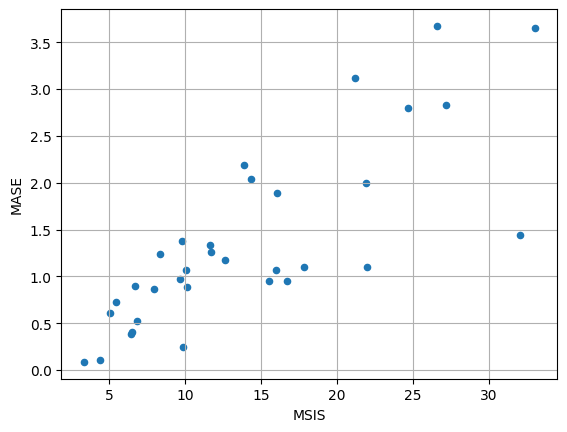

In [626]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

#### Save existing model

In [74]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/tmp/"))

# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

#### Write a document here

In [316]:
#### Feed forward neural network
#### LSTM
#### DeepAR
#### Tranformer

#### Metrics